# ZymoBiomics Community Standard 

ZymoBIOMICS Microbial Community Standard
eight bacteria(3 Gram-negative and 5 Gram-positive)and 2 yeasts.
```
Species	NRRL_Accession_NO.	Strain_Name	GenBank_assession
Bacillus subtilus	B-354	ATCC 6633	GCA_006094475.1
Cryptococcus neoformans	Y-2534	ATCC 32719	GCA_002216205.1 
Enterococcus faecalis	B-537	ATCC 7080	GCA_000393015.1
Escherichia coli	B-1109	01485cm	GCA_005153645.1
Lactobacillus fermentum	B-1840	ATCC 14931	GCA_000159215.1
Listeria monocytogenes	B-33116	ATCC 19117	GCA_000307025.1
Psuedomonas aeruginosa	B-3509	ATCC 15442	GCA_000504485.1
Saccharomyces cerevisiae	Y-567	ATCC 9763	GCA_007556415.1
Salmonella enterica	B-4212	TA1536	GCA_005154105.1 
Staphylococcus aureus	B-41012	Rosenbach 1884	GCA_005153985.1

```

## single cell analysis with reference genome

The sample was processed using EASi-seq and the libary was sequenced on a partial lane on Illumina Novaseq by Novogene.

data saved in folder: "./Zymo_novoseq4/raw/"
```
./Zymo_novoseq4/raw/zymo_a_CKDL210015590-1a-N705-N505_HJMNKDSX2_L4_R1.fastq.gz  
./Zymo_novoseq4/raw/zymo_b_CKDL210015590-1a-N706-N506_HJMNKDSX2_L4_R1.fastq.gz
./Zymo_novoseq4/raw/zymo_a_CKDL210015590-1a-N705-N505_HJMNKDSX2_L4_R2.fastq.gz  
./Zymo_novoseq4/raw/zymo_b_CKDL210015590-1a-N706-N506_HJMNKDSX2_L4_R2.fastq.gz
```

### Reference genome 
the reference is downloaded from (updated on September 29, 2017)
wget https://s3.amazonaws.com/zymo-files/BioPool/ZymoBIOMICS.STD.refseq.v2.zip
unzip * 

reference genome saved in 
/drive4/xiangpeng/Project/bacteria/mRNA-seq/fastq/zymo/ref/std/ZymoBIOMICS.STD.refseq.v2/Genomes
```
-rw-rw-r-- 1 xiangpeng xiangpeng 4.6M Feb 21  2020 Salmonella_enterica_complete_genome.fasta
-rw-rw-r-- 1 xiangpeng xiangpeng 1.9M Feb 21  2020 Lactobacillus_fermentum_complete_genome.fasta
-rw-r--r-- 1 xiangpeng xiangpeng  13M Feb 20  2018 Saccharomyces_cerevisiae_draft_genome.fasta
-rw-rw-r-- 1 xiangpeng xiangpeng 3.9M Oct 29  2017 Bacillus_subtilis_complete_genome.fasta
-rw-rw-r-- 1 xiangpeng xiangpeng 2.7M Sep 26  2017 Staphylococcus_aureus_complete_genome.fasta
-rw-rw-r-- 1 xiangpeng xiangpeng 6.5M Sep 26  2017 Pseudomonas_aeruginosa_complete_genome.fasta
-rw-rw-r-- 1 xiangpeng xiangpeng 2.9M Sep 26  2017 Listeria_monocytogenes_complete_genome.fasta
-rw-rw-r-- 1 xiangpeng xiangpeng 4.7M Sep 26  2017 Escherichia_coli_complete_genome.fasta
-rw-rw-r-- 1 xiangpeng xiangpeng 2.8M Sep 26  2017 Enterococcus_faecalis_complete_genome.fasta
-rw-rw-r-- 1 xiangpeng xiangpeng  28M Sep 26  2017 Cryptococcus_neoformans_draft_genome.fasta
```

combine all the files as one fasta file for reference
cat *.fasta > zymo_all.fa
ls */*.fasta | parallel "grep '>' {} | sed 's/>//g' | cut -f 1 -d ' '  > {.}.txt"
ls *.txt > all_zymo_contig.list
#build bowtie2 index
bowtie2-build  --threads 32  /drive4/xiangpeng/Project/bacteria/mRNA-seq/fastq/zymo/ref/std/ZymoBIOMICS.STD.refseq.v2/Genomes/all.fa /drive4/xiangpeng/Project/bacteria/mRNA-seq/fastq/zymo/ref/std/ZymoBIOMICS.STD.refseq.v2/Genomes/zymo
 

### Barcode extraction 
Run mb_barcode_and_trim command to extract the barcode from raw sequencing data FASTQ files

##### Step 1: Barcode extraction

#run the following code in the command line

In [ ]:
!mkdir ./splited/zymo/
!python2 ./missionbio-tools/mb_barcode_and_trim_scwga.py Zymo ./Zymo_novoseq4/raw/ ./splited/zymo/ --chem_version V2 --r1_min_len 30 --r2_min_len 30 --min_reads 1000

#this command generate the following documents:
1. the barcode extracted fastq files: "Zymo_R1.fastq.gz", "Zymo_R1.fastq.gz"

The barcode sequence has been writen to the header in each entry, shown as following. 
```
@A00742:269:HJMNKDSX2:4:1101:1108:1031_TTGTATCACTCAGAGCGT-1
GCAGCAAGCAAGCTATTATAAAAACCGAGAAATGGAGTTAGCGCTTTCATAAAACTGAAAACGCGCGATTGAGATTTACCTAA
+
FFFFFFF,FFF,F:F:FFFFFFFF:F:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFF:F:FF
```
2. A CSV file of read counts in each barcode group: "zymo_barcode_counts.tsv"   

3. Individual pair-end fastq files for each barcode groups (with min read of 1000), such as TTGTATCACTCAGAGCGT-1_R1.fq and TTGTATCACTCAGAGCGT-1_R2.fq

##### Step 2: Filter the barcodes by read counts 

In [2]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import os

In [3]:
# analysis filenames
exp_dir = './splited/zymo/'
tsv_path = exp_dir + 'zymo_barcode_counts.tsv'
out_dir = './splited/zymo/ref_analysis/'


In [4]:
# analysis filenames
exp_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/'
tsv_path = exp_dir + 'zymo_barcode_counts.tsv'
sam_path = exp_dir + 'output/Zymo_mapped_filtered.sam'
out_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/ref_analysis/'


## Call valid cells

In [3]:
# extract barcodes and read totals
all_df = pd.read_csv(tsv_path, sep='\t', index_col=0)

barcodes_all = list(all_df.index)
reads_per_cell = [int(i) for i in list(all_df.sum(axis=1))]

total_reads = sum(reads_per_cell)

reads_per_cell, barcodes_all = (list(t) for t in zip(*sorted(zip(reads_per_cell, barcodes_all), reverse=True)))

print('%d total barcoded reads in experiment' % total_reads)

238362513 total barcoded reads in experiment


Text(0, 0.5, 'Reads per Cell')

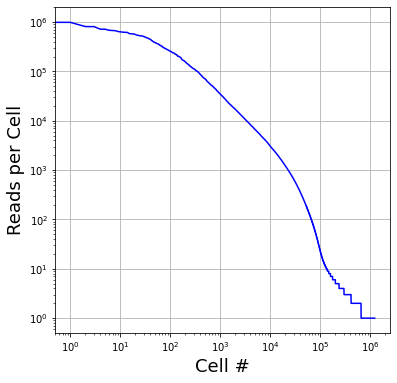

In [4]:
# plot log-log reads per cell vs cells
plt.figure(figsize=(6, 6))
ax = plt.axes()
ax.grid()
plt.loglog(range(len(reads_per_cell)), reads_per_cell, color='b')
plt.xlabel('Cell #', fontsize=18)
plt.ylabel('Reads per Cell', fontsize=18)

In [14]:
# set minimum number of reads per cell
#min_reads = 5000
min_reads = 2000
# create dataframe for called cells only
min_reads_df = all_df.loc[(all_df.sum(axis=1) >= min_reads), :]
valid_barcodes = list(min_reads_df.index)

# print stats
print('%d cells called' % len(min_reads_df.index))
frac_cells = min_reads_df.values.sum()/total_reads
print('Fraction of reads belonging to valid cells: %0.4f' % frac_cells)

14175 cells called
Fraction of reads belonging to valid cells: 0.8631


In [15]:
with open(exp_dir + "valid_barcodes.txt", "w") as f:
    for bar in valid_barcodes:
        f.write(bar +"\n")   
#valide barcodes saved in file valid_barcodes.txt

In [16]:
len(valid_barcodes)

14175

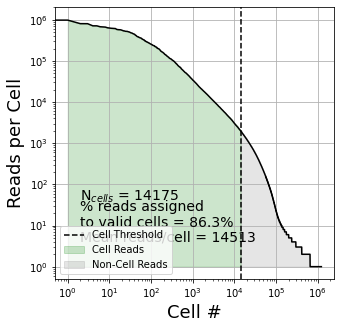

In [17]:
# plot log-log reads per cell vs cells
n_cells =len(min_reads_df.index)
reads_per_cell.sort(reverse=True)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.grid()
plt.loglog(range(len(reads_per_cell)), reads_per_cell, color='k')
plt.axvline(x=n_cells, color='k', linestyle='--', label='Cell Threshold')
plt.xlabel('Cell #', fontsize=18)
plt.ylabel('Reads per Cell', fontsize=18)

t1 = plt.annotate('N' + r'$_{cells}$' + ' = %d' % n_cells, xy=(2,40), fontsize=14)
t1.set_bbox(dict(facecolor=None, edgecolor=None, alpha=0))

per_valid = sum(reads_per_cell[0:n_cells]) / sum(reads_per_cell) * 100
t2 = plt.annotate('%% reads assigned\nto valid cells = %0.1f%%' % per_valid, xy=(2,9), fontsize=14)
t2.set_bbox(dict(facecolor=None, edgecolor=None, alpha=0))

t3 = plt.annotate('Mean reads/cell = %d' % np.mean(reads_per_cell[:n_cells]), xy=(2,4), fontsize=14)
t3.set_bbox(dict(facecolor=None, edgecolor=None, alpha=0))

# fill auc
plt.fill_between(range(1, n_cells), reads_per_cell[1:n_cells], [1] * (n_cells - 1), color='g', alpha=0.2, label='Cell Reads')
total_barcodes = len(reads_per_cell)
plt.fill_between(range(n_cells, total_barcodes), reads_per_cell[n_cells:], [1] * (total_barcodes - n_cells), color='grey', alpha=0.2, label='Non-Cell Reads')
plt.legend()

###  Align reads to refence genome


In [5]:
fq_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/fq/'
bam_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/bam/'
ref =  '/drive4/xiangpeng/Project/bacteria/mRNA-seq/fastq/zymo/ref/std/ZymoBIOMICS.STD.refseq.v2/Genomes/zymo'

valid_bar = pd.read_csv("/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/valid_barcodes.txt", names = ['bar'])['bar'].tolist()

for bar in valid_bar:
    fa1 = fq_dir + bar+ '_R1.fq'
    fa2 = fq_dir + bar+ '_R2.fq'
    bam = bam_dir + bar + '.bam'
    log = bam_dir + bar +'.log'
    bt2_cmd = '(bowtie2 -x {} -p 32 -1 {} -2 {} | samtools view -@ 32 -Sb -o {}) 2>{}'.format(ref, fa1, fa2, bam, log)
    #os.system(bt2_cmd)

### Filter reads by alignment rate

In [6]:
bar_align = pd.DataFrame(columns = ['bar', 'alignment_rate','read_cnt'])
for bar in valid_bar:
    log_file = bam_dir + bar +'.log'
    log = open(log_file, 'r')
    lines = log.readlines()
    log.close()
    oar = float(lines[-1].split('%')[0])
    cnt = int(lines[0].split(' ')[0])
    bar_align.loc[len(bar_align.index)] = [bar, oar, cnt] 

bar_align=bar_align.set_index('bar')  
bar_align

,alignment_rate,read_cnt
bar,,
ACGCAAGATAGTTGCCTT-1,0.54,2765
AGCCGGATCGATCGCGAA-1,0.40,15331
CGGATTCTCGCCTGCATC-1,95.82,2464
GATAACGTCAGCATTCCA-1,95.99,6982
GGACGAGCAAAGGAAGTC-1,0.76,6073
...,...,...
TTCCTTGACCTTATTGAG-2,0.33,3027
GAATCACATATTAGCCAC-2,0.59,5071
CCTTGCTTGTGAACCAAT-2,94.70,34280


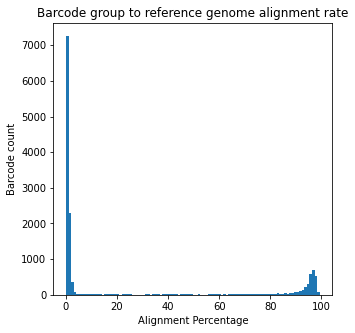

In [7]:
plt.figure(figsize=(5,5))
bar_align['alignment_rate'].plot.hist(bins=100, )
plt.title('Barcode group to reference genome alignment rate')
plt.ylabel('Barcode count')
#plt.yscale('log')
plt.xlabel('Alignment Percentage')
plt.show()

In [74]:
bar_align.to_csv(out_dir+'zymo_alignmen_read_cnt_prior_filter.csv')

In [8]:
bar_align_filtered = bar_align[bar_align['alignment_rate']>50]
bar_align_filtered.to_csv(out_dir+'zymo_alignmen_read_cnt_after_filter.csv')

In [80]:
out_dir

'/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/ref_analysis/'

### Coverage calculation 

In [10]:
filtered_bars =  bar_align_filtered.index.tolist()
len(filtered_bars)

3632

In [12]:
# extract the species contig information to make a dictionary. 
fa_dir = '/drive4/xiangpeng/Project/bacteria/mRNA-seq/fastq/zymo/ref/std/ZymoBIOMICS.STD.refseq.v2/Genomes/fastas/'
contig_ls = pd.read_csv(fa_dir + 'zymo_contig.list', names=['file'])['file'].to_list()
contig_species_dict = {}
species = []
for f in contig_ls:
    specie = f.split('_')[0]
    
    contigs = pd.read_csv(fa_dir + f, names=['contigs'])['contigs'].tolist()
    species.append(specie)
    for c in contigs:
        contig_species_dict[str(c)]=specie
        
#contig_species_dict

In [95]:
contig_species_dict[35066]

'Cryptococcus'

In [66]:
#cycle through the filtered barcodes, and use samtools to calculate the coverage for each contig
for bar in filtered_bars[:1]:
    bam = bam_dir + bar + '.bam'
    cov = bam_dir + bar + '.cov'
    cov_cmd = "samtools view {} -b -q 2 -@ 32 |samtools sort -@ 32 - | samtools coverage -  > {}".format(bam,cov)
    print(cov_cmd)

samtools view /drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/bam/CGGATTCTCGCCTGCATC-1.bam -b -q 2 -@ 32 |samtools sort -@ 32 - | samtools coverage -  > /drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/bam/CGGATTCTCGCCTGCATC-1.cov


In [13]:
spc_read_cnt = pd.DataFrame() # read count of each barcode that aligned to each species
spc_covered_base = pd.DataFrame() # covered base count count of each barcode that aligned to each species
spc_coverage = pd.DataFrame() # coverage of each species in each barcode
for bar in filtered_bars:
    cov = bam_dir + bar + '.cov'
    cov_df =  pd.read_csv(cov, index_col =0,sep='\t' )
    cov_df.index.astype(str, copy = False)
    cov_df['species'] = cov_df.index.map(contig_species_dict)
    spc_df =  cov_df.groupby('species').sum()
    spc_df['coverage']= spc_df['covbases']/spc_df['endpos']
    spc_read_cnt = pd.concat([spc_read_cnt,spc_df['numreads']], axis =1 )
    spc_read_cnt = spc_read_cnt.rename(columns = {'numreads':bar})
    
    spc_covered_base = pd.concat([spc_covered_base,spc_df['covbases']], axis =1 )
    spc_covered_base = spc_covered_base.rename(columns = {'covbases':bar})
    
    spc_coverage = pd.concat([spc_coverage,spc_df['coverage']], axis =1 )
    spc_coverage = spc_coverage.rename(columns = {'coverage':bar})

In [124]:
spc_read_cnt.to_csv(out_dir + 'Zymo_barcode_read_count_mapped_to_species.csv') # read count of each barcode that aligned to each species
spc_covered_base.to_csv(out_dir + 'Zymo_barcode_covered_base_count_mapped_to_species.csv') # covered base count count of each barcode that aligned to each species
spc_coverage.to_csv(out_dir + 'Zymo_barcode_coverage_mapped_to_species.csv')# coverage of each species in each barcode

In [14]:
spc_bar_read_cnt = spc_read_cnt.T
spc_bar_read_cnt['total_read']=spc_bar_read_cnt[species].sum(axis=1)

In [15]:
spc_bar_read_cnt['Purity']=spc_bar_read_cnt[species].max(axis=1)/spc_bar_read_cnt['total_read']

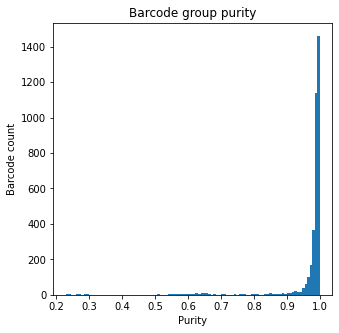

In [16]:

plt.figure(figsize=(5,5))
spc_bar_read_cnt['Purity'].plot.hist(bins=100)
plt.title('Barcode group purity')
plt.ylabel('Barcode count')
#plt.yscale('log')
plt.xlabel('Purity')
plt.show()

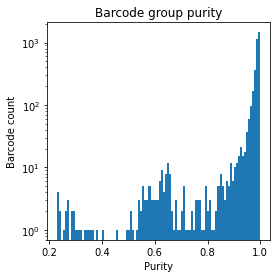

In [17]:

plt.figure(figsize=(4,4))
spc_bar_read_cnt['Purity'].plot.hist(bins=100)
plt.title('Barcode group purity')
plt.ylabel('Barcode count')
plt.yscale('log')
plt.xlabel('Purity')
plt.show()

In [18]:
min_purity = 0.9
spc_bar_read_cnt['Species']=spc_bar_read_cnt[species].idxmax(axis=1)
spc_bar_read_cnt.loc[spc_bar_read_cnt['Purity']< min_purity,'Species']= 'Mixed'

In [19]:
spc_bar_read_cnt.head()

,Bacillus,Cryptococcus,Enterococcus,Escherichia,Lactobacillus,Listeria,Pseudomonas,Saccharomyces,Salmonella,Staphylococcus,total_read,Purity,Species
CGGATTCTCGCCTGCATC-1,27,5,4189,127,14,6,0,8,0,10,4386,0.955084,Enterococcus
GATAACGTCAGCATTCCA-1,19,0,24,2,4,0,0,4,6,13333,13392,0.995594,Staphylococcus
TTAACGTTCACTGGTCAG-1,10,3566,6,0,16,2,0,3,0,12,3615,0.986445,Cryptococcus
ACGTATGTCCAATCATAC-1,37,95,83,2,32059,26,0,29,10,52,32393,0.989689,Lactobacillus
CGAGTAGCAGATACTGTG-1,145,58,92,0,134,20,0,57653,0,55,58157,0.991334,Saccharomyces


<AxesSubplot:ylabel='Species'>

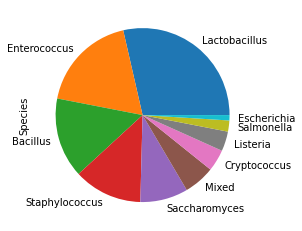

In [149]:
spc_bar_read_cnt['Species'].value_counts().plot.pie()

### Pairplot 

In [162]:
genus = ['Enterococcus' , 
         'Lactobacillus', 
         'Staphylococcus', 
         'Bacillus', 
         'Cryptococcus',
         'Escherichia',
         'Listeria',
         'Pseudomonas',
         'Saccharomyces', 
         'Salmonella',
         'other',
         'Mixed'
        ]

colors = ['#a6cee3',
         '#1f78b4',
         '#b2df8a',
         '#33a02c',
         '#fb9a99',
         '#e31a1c',
         '#fdbf6f',
         '#ff7f00',
         '#cab2d6',
         '#6a3d9a',
         '#ffff99',
         'tab:grey',
         #6a3d9a
#ffff99
#b15928
         ] 

genus_color_table = dict(zip(genus,colors))      
genus_color_table

{'Enterococcus': '#a6cee3',
 'Lactobacillus': '#1f78b4',
 'Staphylococcus': '#b2df8a',
 'Bacillus': '#33a02c',
 'Cryptococcus': '#fb9a99',
 'Escherichia': '#e31a1c',
 'Listeria': '#fdbf6f',
 'Pseudomonas': '#ff7f00',
 'Saccharomyces': '#cab2d6',
 'Salmonella': '#6a3d9a',
 'other': '#ffff99',
 'Mixed': 'tab:grey'}

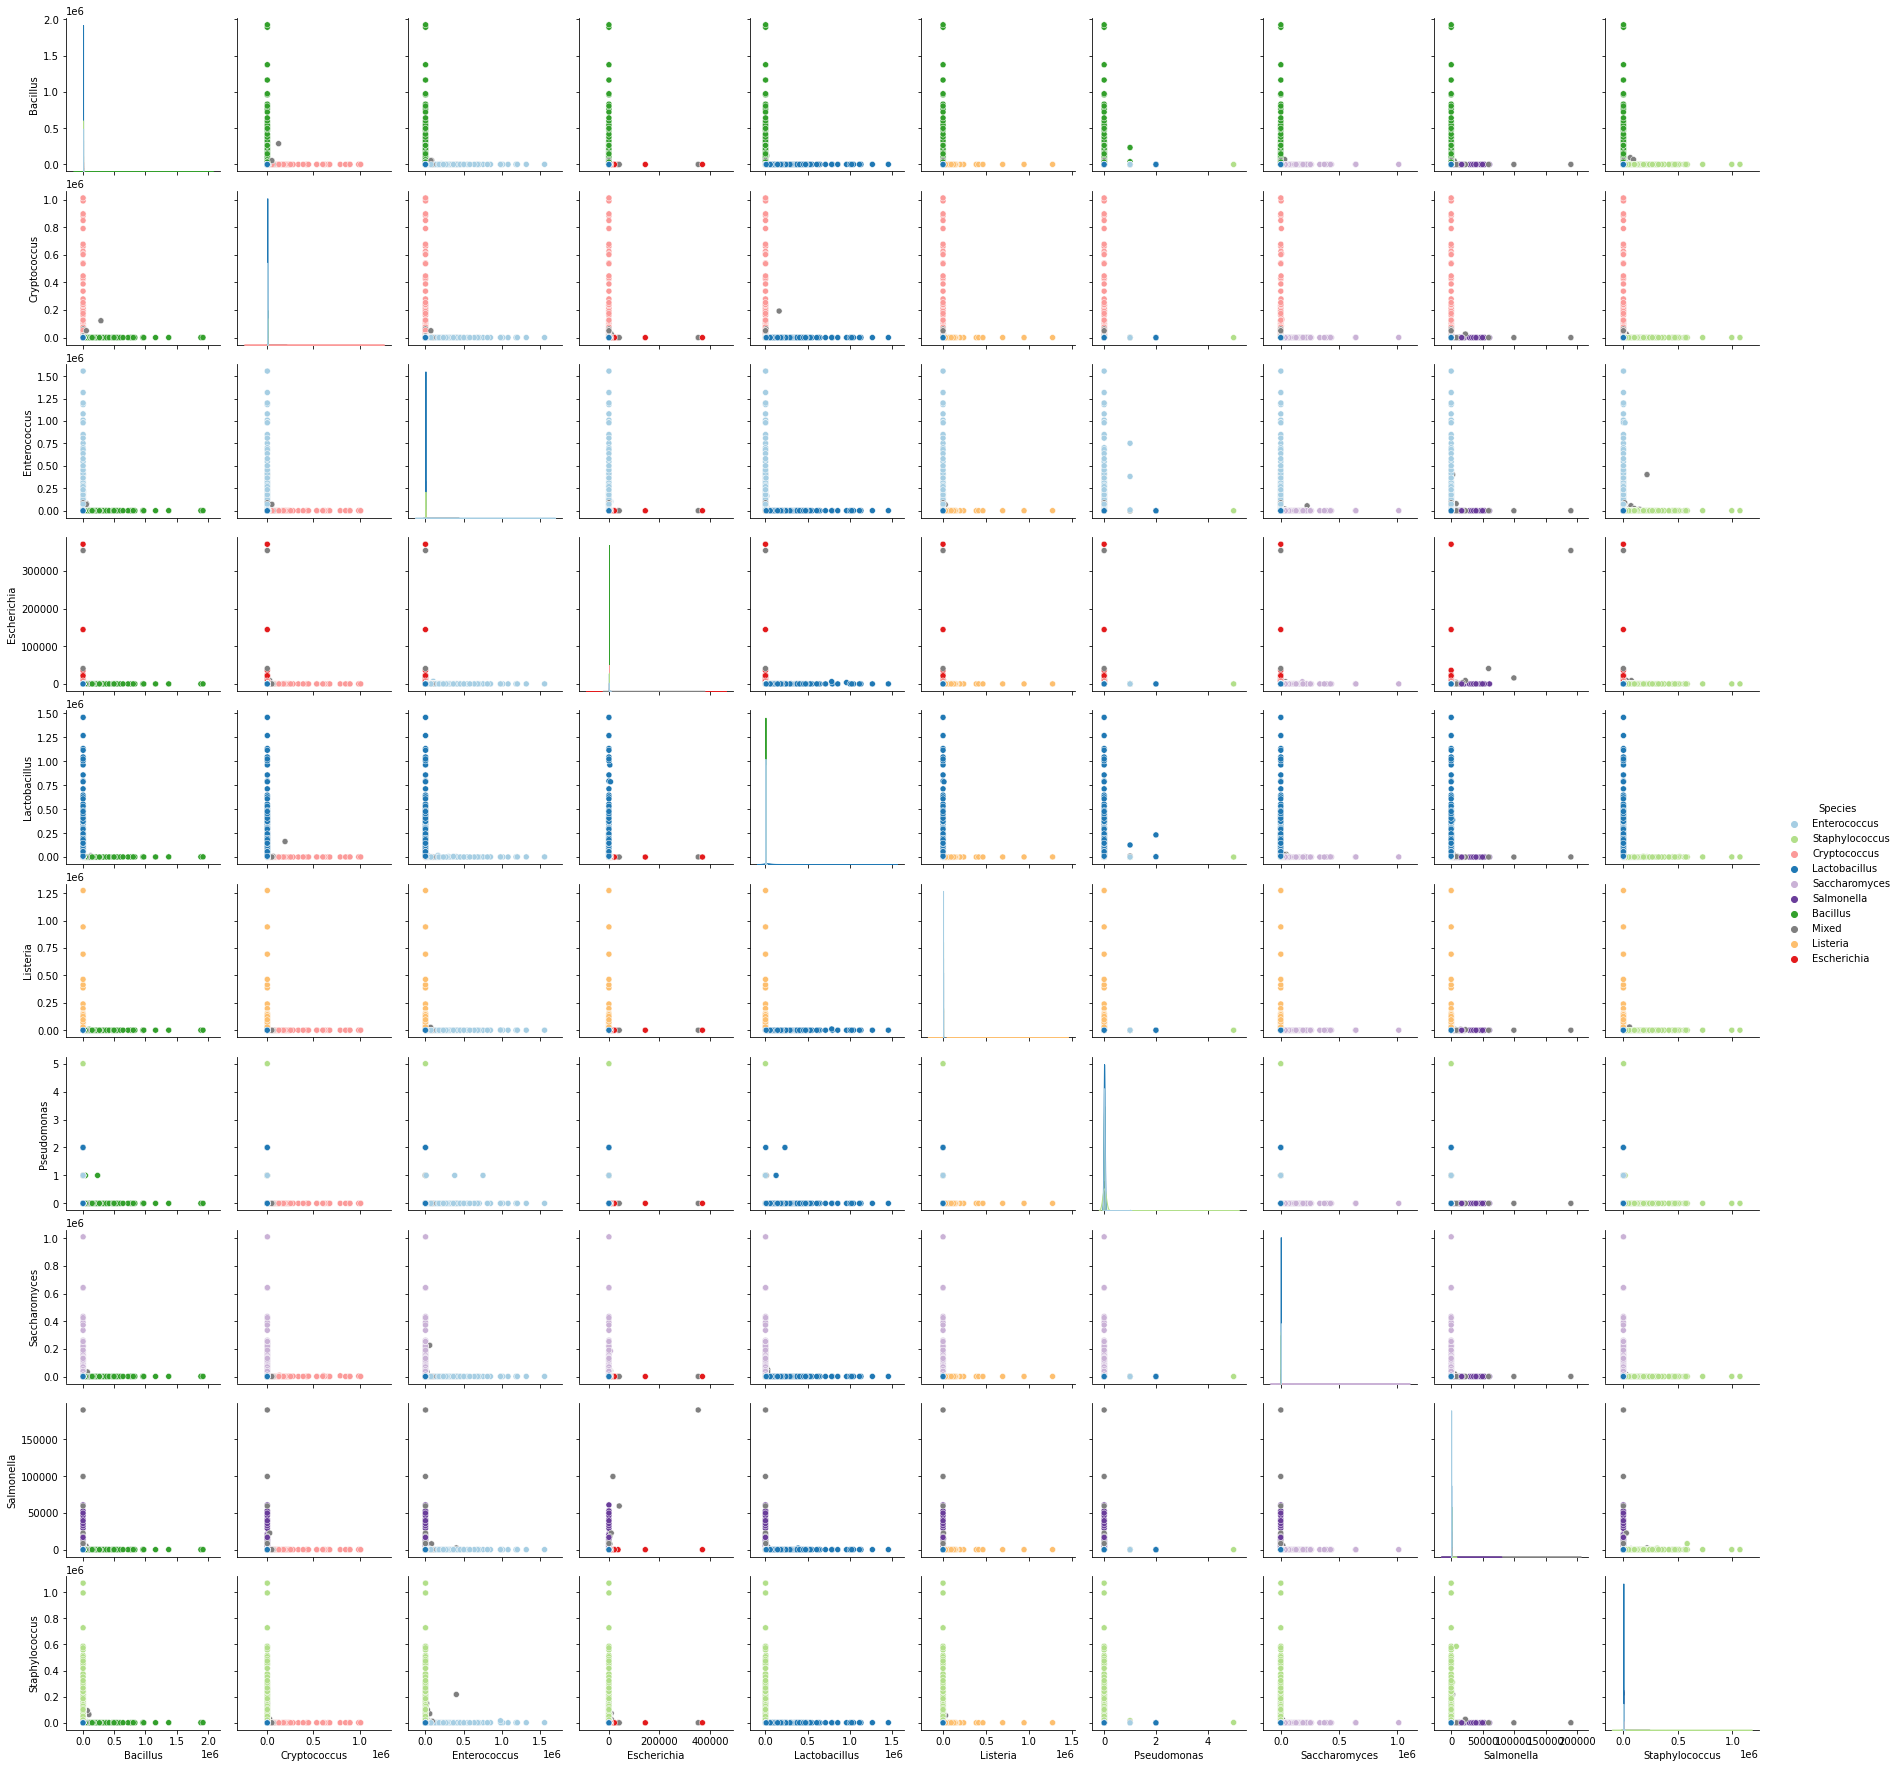

In [163]:
import seaborn as sns
sns_plot = sns.pairplot(spc_bar_read_cnt.drop(columns = ['total_read','Purity']),
                        hue = 'Species',
                        palette =genus_color_table 
                       )
plt.savefig(out_dir+'zymo_pairplot.pdf', bbox_inches='tight')


In [167]:
spc_coverage_df = spc_coverage.T
spc_coverage_df['Species']= spc_bar_read_cnt['Species']

#### The coverage Vs read count plot

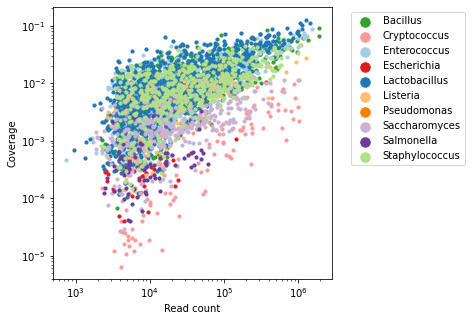

In [174]:
plt.figure(figsize=(5,5))
plt.xlabel('Read count')
plt.ylabel('Coverage')
plt.yscale('log')
plt.xscale('log')
for specie in species:
    x = spc_bar_read_cnt[spc_bar_read_cnt['Species']==specie][specie]
    y = spc_coverage_df[spc_coverage_df['Species']==specie][specie]
    color= genus_color_table[specie]
    
    plt.scatter(x,y, label =specie, c =color, s = 10)
    
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                 #fontsize =15, 
                 markerscale =3
                ) 
#plt.show()
plt.savefig(out_dir + 'Zymo_coverage_vs_readcount.pdf', bbox_inches='tight')



In [22]:
spc_read_cnt.to_csv(out_dir + 'Zymo_barcode_read_count_mapped_to_species.csv') # read count of each barcode that aligned to each species
spc_covered_base.to_csv(out_dir + 'Zymo_barcode_covered_base_count_mapped_to_species.csv') # covered base count count of each barcode that aligned to each species
spc_coverage.to_csv(out_dir + 'Zymo_barcode_coverage_mapped_to_species.csv')# coverage of each species in each barcode

In [21]:
spc_bar_read_cnt.to_csv(out_dir + 'Zymo_barcode_read_count_mapped_to_species_filtered.csv')